# Import

In [ ]:
import os

import pandas as pd

import warnings

import numpy as np

import csv

import time

import statistics

import random

import warnings

# Plot
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional


# Signal processing
from scipy.signal import resample, iirnotch, butter, lfilter, filtfilt

# Feature extraction functions
from scipy.signal import welch
from scipy.stats import skew, kurtosis

# Model
import lightgbm as lgb

# Explainability
import shap

from typing import Dict, List, Tuple

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
    matthews_corrcoef,
    cohen_kappa_score
)

# Features

In [2]:
# comment out any feature to see performance variation

feature_names = [
        'Mean Absolute Value',           # 0
        'Root Mean Square',              # 1
        'Zero Crossings',                # 2
        'Peak Frequency',                # 3
        'Mean Frequency',                # 4
        'Median Frequency',              # 5
        'Total Power',                   # 6
        'Variance',                      # 7
        'Shannon Entropy',               # 8
        'Signal Skewness',               # 9
        'Signal Kurtosis',               # 10
        'Petrosian FD',                  # 11
        'Slope Sign Changes',            # 12
        'Waveform Length',               # 13
        'SNR',                           # 14
        'Recurrence',                    # 15
        'Muscle'                         # 16  
    ]

# Functions

## Data Loading

In [3]:
def load_emg_dataset(dataset_path, frequency, record_length):
    """
    Load EMG dataset from directory structure with robust data validation.
    
    Parameters:
    - dataset_path: str, path to the dataset directory
    - frequency: int, sampling frequency in Hz
    - record_length: int, record length in seconds
    
    Returns:
    - dataset: dict, nested dictionary containing EMG data
    """
    expected_samples = frequency * record_length
    
    # Initialize the dataset dictionary
    dataset = {
        'Deltoid': {
            'Healthy': [],
            'Myopathy': [],
            'Neuropathy': []
        },
        'Biceps': {
            'Healthy': [],
            'Myopathy': [],
            'Neuropathy': []
        }
    }
    
    # Mapping from directory names to dictionary keys
    muscle_mapping = {
        '01_Deltoid': 'Deltoid',
        '02_Biceps Brachii': 'Biceps'
    }
    
    condition_dirs = ['Healthy', 'Myopathy', 'Neuropathy']
    
    # Thresholds for data validation - specific for each condition
    condition_thresholds = {
        'Healthy': {'max': 6000.0, 'min': -6000.0},
        'Myopathy': {'max': 4000.0, 'min': -4000.0},
        'Neuropathy': {'max': 9000.0, 'min': -9000.0}
    }
    
    EPSILON = 0.0001
    
    # Load the data
    for muscle_dir, muscle_key in muscle_mapping.items():
        muscle_path = os.path.join(dataset_path, muscle_dir)
        
        if not os.path.exists(muscle_path):
            continue
        
        for condition in condition_dirs:
            condition_path = os.path.join(muscle_path, condition)
            
            if not os.path.exists(condition_path):
                continue
            
            # Get condition-specific thresholds
            MAX_VALUE = condition_thresholds[condition]['max']
            MIN_VALUE = condition_thresholds[condition]['min']
            
            # Get all .asc files in the condition directory
            asc_files = [f for f in os.listdir(condition_path) if f.endswith('.asc')]
            
            for asc_file in asc_files:
                file_path = os.path.join(condition_path, asc_file)
                file_identifier = f"{muscle_key}/{condition}/{asc_file}"
                
                try:
                    # Read the file and parse the EMG values
                    with open(file_path, 'r') as f:
                        content = f.read()
                        # Split by whitespace and convert to float
                        emg_values = [float(x) for x in content.split()]
                    
                    # Check length and adjust
                    if len(emg_values) < expected_samples:
                        print(f"ERROR - SHORT RECORD: {file_identifier}")
                        continue
                    elif len(emg_values) > expected_samples:
                        emg_values = emg_values[:expected_samples]
                    
                    # Validate and clean the data
                    cleaned_values = []
                    has_errors = False
                    error_counts = {
                        'nan': 0,
                        'complex': 0,
                        'too_large': 0,
                        'too_small': 0,
                        'infinitesimal': 0
                    }
                    
                    for i, value in enumerate(emg_values):
                        # Check for NaN
                        if np.isnan(value):
                            error_counts['nan'] += 1
                            has_errors = True
                            cleaned_values.append(0.0)
                            continue
                        
                        # Check for infinity
                        if np.isinf(value):
                            has_errors = True
                            if value > 0:
                                error_counts['too_large'] += 1
                                cleaned_values.append(MAX_VALUE)
                            else:
                                error_counts['too_small'] += 1
                                cleaned_values.append(MIN_VALUE)
                            continue
                        
                        # Convert to float (should already be, but ensures it)
                        value = float(value)
                        
                        # Check for extremely large values
                        if value > MAX_VALUE:
                            error_counts['too_large'] += 1
                            has_errors = True
                            cleaned_values.append(MAX_VALUE)
                        # Check for extremely small (negative) values
                        elif value < MIN_VALUE:
                            error_counts['too_small'] += 1
                            has_errors = True
                            cleaned_values.append(MIN_VALUE)
                        # Check for infinitesimal values
                        elif abs(value) < EPSILON and value != 0.0:
                            error_counts['infinitesimal'] += 1
                            has_errors = True
                            cleaned_values.append(0.0)
                        else:
                            cleaned_values.append(value)
                    
                    # Report errors if any were found
                    if has_errors:
                        print(f"\nWARNING - DATA QUALITY ISSUES: {file_identifier}")
                        print(f"  [Thresholds for {condition}: {MIN_VALUE} to {MAX_VALUE}]")
                        if error_counts['nan'] > 0:
                            print(f"  - NaN values: {error_counts['nan']} (replaced with 0.0)")
                        if error_counts['too_large'] > 0:
                            print(f"  - Values > {MAX_VALUE}: {error_counts['too_large']} (clipped to {MAX_VALUE})")
                        if error_counts['too_small'] > 0:
                            print(f"  - Values < {MIN_VALUE}: {error_counts['too_small']} (clipped to {MIN_VALUE})")
                        if error_counts['infinitesimal'] > 0:
                            print(f"  - Infinitesimal values (|x| < {EPSILON}): {error_counts['infinitesimal']} (set to 0.0)")
                        if error_counts['complex'] > 0:
                            print(f"  - Complex values: {error_counts['complex']}")
                    
                    # Verify all values are proper floats
                    cleaned_values = [float(v) for v in cleaned_values]
                    
                    # Add to dataset
                    dataset[muscle_key][condition].append({
                        'File Name': asc_file,
                        'EMG': cleaned_values
                    })
                    
                except ValueError as e:
                    # This catches complex numbers and other parsing issues
                    if 'complex' in str(e).lower() or 'j' in content.lower():
                        print(f"ERROR - COMPLEX NUMBERS DETECTED: {file_identifier}")
                    else:
                        print(f"ERROR - PARSING FAILED: {file_identifier} - {e}")
                    continue
                    
                except Exception as e:
                    print(f"ERROR - LOADING FAILED: {file_identifier} - {e}")
                    continue
    
    print("\n" + "="*50)
    print("Dataset loaded successfully")
    print("="*50)
    
    # Display summary with thresholds
    print("\nCondition-specific thresholds:")
    print("-"*40)
    for condition in ['Healthy', 'Myopathy', 'Neuropathy']:
        thresholds = condition_thresholds[condition]
        print(f"{condition}: [{thresholds['min']}, {thresholds['max']}]")
    
    print("\nDataset Summary:")
    print("="*40)
    for muscle in ['Deltoid', 'Biceps']:
        print(f"{muscle}:")
        for condition in ['Healthy', 'Myopathy', 'Neuropathy']:
            count = len(dataset[muscle][condition])
            print(f"  {condition}: {count} files")
    
    return dataset

In [4]:
def load_raw_emg_dataset(dataset_path, frequency, record_length):
    """
    Load EMG dataset from directory structure with robust data validation.
    
    Parameters:
    - dataset_path: str, path to the dataset directory
    - frequency: int, sampling frequency in Hz
    - record_length: int, record length in seconds
    
    Returns:
    - dataset: dict, nested dictionary containing EMG data
    """
    expected_samples = frequency * record_length
    
    # Initialize the dataset dictionary
    dataset = {
        'Deltoid': {
            'Healthy': [],
            'Myopathy': [],
            'Neuropathy': []
        },
        'Biceps': {
            'Healthy': [],
            'Myopathy': [],
            'Neuropathy': []
        }
    }
    
    # Mapping from directory names to dictionary keys
    muscle_mapping = {
        '01_Deltoid': 'Deltoid',
        '02_Biceps Brachii': 'Biceps'
    }
    
    condition_dirs = ['Healthy', 'Myopathy', 'Neuropathy']
    
    # Thresholds for data validation - specific for each condition
    condition_thresholds = {
        'Healthy': {'max': 15000.0, 'min': -15000.0},
        'Myopathy': {'max': 15000.0, 'min': -15000.0},
        'Neuropathy': {'max': 20000.0, 'min': -20000.0}
    }
    
    EPSILON = 0.0001
    
    # Load the data
    for muscle_dir, muscle_key in muscle_mapping.items():
        muscle_path = os.path.join(dataset_path, muscle_dir)
        
        if not os.path.exists(muscle_path):
            continue
        
        for condition in condition_dirs:
            condition_path = os.path.join(muscle_path, condition)
            
            if not os.path.exists(condition_path):
                continue
            
            # Get condition-specific thresholds
            MAX_VALUE = condition_thresholds[condition]['max']
            MIN_VALUE = condition_thresholds[condition]['min']
            
            # Get all .asc files in the condition directory
            asc_files = [f for f in os.listdir(condition_path) if f.endswith('.asc')]
            
            for asc_file in asc_files:
                file_path = os.path.join(condition_path, asc_file)
                file_identifier = f"{muscle_key}/{condition}/{asc_file}"
                
                try:
                    # Read the file and parse the EMG values
                    with open(file_path, 'r') as f:
                        content = f.read()
                        # Split by whitespace and convert to float
                        emg_values = [float(x) for x in content.split()]
                    
                    # Check length and adjust
                    if len(emg_values) < expected_samples:
                        print(f"ERROR - SHORT RECORD: {file_identifier}")
                        continue
                    elif len(emg_values) > expected_samples:
                        emg_values = emg_values[:expected_samples]
                    
                    # Validate and clean the data
                    cleaned_values = []
                    has_errors = False
                    error_counts = {
                        'nan': 0,
                        'complex': 0,
                        'too_large': 0,
                        'too_small': 0,
                        'infinitesimal': 0
                    }
                    
                    for i, value in enumerate(emg_values):
                        # Check for NaN
                        if np.isnan(value):
                            error_counts['nan'] += 1
                            has_errors = True
                            cleaned_values.append(0.0)
                            continue
                        
                        # Check for infinity
                        if np.isinf(value):
                            has_errors = True
                            if value > 0:
                                error_counts['too_large'] += 1
                                cleaned_values.append(MAX_VALUE)
                            else:
                                error_counts['too_small'] += 1
                                cleaned_values.append(MIN_VALUE)
                            continue
                        
                        # Convert to float (should already be, but ensures it)
                        value = float(value)
                        
                        # Check for extremely large values
                        if value > MAX_VALUE:
                            error_counts['too_large'] += 1
                            has_errors = True
                            cleaned_values.append(MAX_VALUE)
                        # Check for extremely small (negative) values
                        elif value < MIN_VALUE:
                            error_counts['too_small'] += 1
                            has_errors = True
                            cleaned_values.append(MIN_VALUE)
                        # Check for infinitesimal values
                        elif abs(value) < EPSILON and value != 0.0:
                            error_counts['infinitesimal'] += 1
                            has_errors = True
                            cleaned_values.append(0.0)
                        else:
                            cleaned_values.append(value)
                    
                    # Report errors if any were found
                    if has_errors:
                        print(f"\nWARNING - DATA QUALITY ISSUES: {file_identifier}")
                        print(f"  [Thresholds for {condition}: {MIN_VALUE} to {MAX_VALUE}]")
                        if error_counts['nan'] > 0:
                            print(f"  - NaN values: {error_counts['nan']} (replaced with 0.0)")
                        if error_counts['too_large'] > 0:
                            print(f"  - Values > {MAX_VALUE}: {error_counts['too_large']} (clipped to {MAX_VALUE})")
                        if error_counts['too_small'] > 0:
                            print(f"  - Values < {MIN_VALUE}: {error_counts['too_small']} (clipped to {MIN_VALUE})")
                        if error_counts['infinitesimal'] > 0:
                            print(f"  - Infinitesimal values (|x| < {EPSILON}): {error_counts['infinitesimal']} (set to 0.0)")
                        if error_counts['complex'] > 0:
                            print(f"  - Complex values: {error_counts['complex']}")
                    
                    # Verify all values are proper floats
                    cleaned_values = [float(v) for v in cleaned_values]
                    
                    # Add to dataset
                    dataset[muscle_key][condition].append({
                        'File Name': asc_file,
                        'EMG': cleaned_values
                    })
                    
                except ValueError as e:
                    # This catches complex numbers and other parsing issues
                    if 'complex' in str(e).lower() or 'j' in content.lower():
                        print(f"ERROR - COMPLEX NUMBERS DETECTED: {file_identifier}")
                    else:
                        print(f"ERROR - PARSING FAILED: {file_identifier} - {e}")
                    continue
                    
                except Exception as e:
                    print(f"ERROR - LOADING FAILED: {file_identifier} - {e}")
                    continue
    
    print("\n" + "="*50)
    print("Dataset loaded successfully")
    print("="*50)
    
    # Display summary with thresholds
    print("\nCondition-specific thresholds:")
    print("-"*40)
    for condition in ['Healthy', 'Myopathy', 'Neuropathy']:
        thresholds = condition_thresholds[condition]
        print(f"{condition}: [{thresholds['min']}, {thresholds['max']}]")
    
    print("\nDataset Summary:")
    print("="*40)
    for muscle in ['Deltoid', 'Biceps']:
        print(f"{muscle}:")
        for condition in ['Healthy', 'Myopathy', 'Neuropathy']:
            count = len(dataset[muscle][condition])
            print(f"  {condition}: {count} files")
    
    return dataset

## Signal Processing

Resampling and Filters

In [5]:
def resample_emg(emg, custom_resampling_factor, file_context=""):
    """
    Resample an EMG signal by a custom factor.
    
    Parameters:
    - emg: list or array, amplitude values
    - custom_resampling_factor: int, factor by which to downsample
    - file_context: optional file identifier for error messages
    
    Returns:
    - list: resampled EMG signal
    """
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        # Validate input
        if len(emg_array) == 0:
            print(f"ERROR - Resample{' ['+file_context+']' if file_context else ''}: Empty signal")
            return []
        
        if custom_resampling_factor <= 0:
            print(f"ERROR - Resample{' ['+file_context+']' if file_context else ''}: Invalid resampling factor ({custom_resampling_factor}), using 1")
            custom_resampling_factor = 1
        
        if custom_resampling_factor > len(emg_array):
            print(f"ERROR - Resample{' ['+file_context+']' if file_context else ''}: Resampling factor ({custom_resampling_factor}) larger than signal length ({len(emg_array)}), using signal length")
            custom_resampling_factor = len(emg_array)
        
        new_length = len(emg_array) // custom_resampling_factor
        
        if new_length < 2:
            print(f"ERROR - Resample{' ['+file_context+']' if file_context else ''}: Resampled signal too short ({new_length}), keeping original")
            return emg_array.tolist()
        
        # Check for NaN or Inf in input
        if np.any(np.isnan(emg_array)):
            print(f"WARNING - Resample{' ['+file_context+']' if file_context else ''}: NaN values in input, removing")
            emg_array = np.nan_to_num(emg_array, nan=0.0)
        
        if np.any(np.isinf(emg_array)):
            print(f"WARNING - Resample{' ['+file_context+']' if file_context else ''}: Inf values in input, clipping")
            emg_array = np.nan_to_num(emg_array, posinf=50000.0, neginf=-50000.0)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            resampled = resample(emg_array, new_length)
        
        # Validate output
        if np.any(np.isnan(resampled)):
            print(f"WARNING - Resample{' ['+file_context+']' if file_context else ''}: NaN in output, replacing with 0")
            resampled = np.nan_to_num(resampled, nan=0.0)
        
        if np.any(np.isinf(resampled)):
            print(f"WARNING - Resample{' ['+file_context+']' if file_context else ''}: Inf in output, clipping")
            resampled = np.nan_to_num(resampled, posinf=50000.0, neginf=-50000.0)
        
        return resampled.tolist()
        
    except Exception as e:
        print(f"ERROR - Resample{' ['+file_context+']' if file_context else ''}: {e}")
        return emg if isinstance(emg, list) else emg.tolist()


def apply_notch_filter(emg, sampling_rate=32768, file_context=""):
    """
    Apply a 50Hz notch filter to an EMG signal.
    
    Parameters:
    - emg: list or array, amplitude values
    - sampling_rate: int, sampling frequency in Hz
    - file_context: optional file identifier for error messages
    
    Returns:
    - list: filtered EMG signal
    """
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        # Validate input
        if len(emg_array) == 0:
            print(f"ERROR - Notch Filter{' ['+file_context+']' if file_context else ''}: Empty signal")
            return []
        
        if len(emg_array) < 3:
            print(f"WARNING - Notch Filter{' ['+file_context+']' if file_context else ''}: Signal too short for filtering, returning original")
            return emg_array.tolist()
        
        if sampling_rate <= 0:
            print(f"ERROR - Notch Filter{' ['+file_context+']' if file_context else ''}: Invalid sampling rate ({sampling_rate}), using 32768")
            sampling_rate = 32768
        
        # Check for NaN or Inf
        if np.any(np.isnan(emg_array)):
            print(f"WARNING - Notch Filter{' ['+file_context+']' if file_context else ''}: NaN values in input, removing")
            emg_array = np.nan_to_num(emg_array, nan=0.0)
        
        if np.any(np.isinf(emg_array)):
            print(f"WARNING - Notch Filter{' ['+file_context+']' if file_context else ''}: Inf values in input, clipping")
            emg_array = np.nan_to_num(emg_array, posinf=50000.0, neginf=-50000.0)
        
        nyquist_freq = 0.5 * sampling_rate
        notch_freq = 50  # Central frequency of the notch
        
        # Check if notch frequency is valid
        if notch_freq >= nyquist_freq:
            print(f"WARNING - Notch Filter{' ['+file_context+']' if file_context else ''}: Notch frequency ({notch_freq}) >= Nyquist ({nyquist_freq}), skipping filter")
            return emg_array.tolist()
        
        quality_factor = 30  # Quality factor for the notch filter
        
        try:
            b_notch, a_notch = iirnotch(notch_freq / nyquist_freq, quality_factor)
            
            # Check filter stability
            if np.any(np.isnan(b_notch)) or np.any(np.isnan(a_notch)):
                print(f"ERROR - Notch Filter{' ['+file_context+']' if file_context else ''}: Invalid filter coefficients")
                return emg_array.tolist()
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                # Use filtfilt for zero-phase filtering (more stable)
                filtered = filtfilt(b_notch, a_notch, emg_array)
            
        except Exception as filter_error:
            print(f"ERROR - Notch Filter design{' ['+file_context+']' if file_context else ''}: {filter_error}, skipping filter")
            return emg_array.tolist()
        
        # Validate output
        if np.any(np.isnan(filtered)):
            print(f"WARNING - Notch Filter{' ['+file_context+']' if file_context else ''}: NaN in output, replacing with 0")
            filtered = np.nan_to_num(filtered, nan=0.0)
        
        if np.any(np.isinf(filtered)):
            print(f"WARNING - Notch Filter{' ['+file_context+']' if file_context else ''}: Inf in output, clipping")
            filtered = np.nan_to_num(filtered, posinf=50000.0, neginf=-50000.0)
        
        return filtered.tolist()
        
    except Exception as e:
        print(f"ERROR - Notch Filter{' ['+file_context+']' if file_context else ''}: {e}")
        return emg if isinstance(emg, list) else emg.tolist()


def apply_butterworth_filter(emg, custom_low_cut_frequency, custom_high_cut_frequency, 
                            custom_butterworth_order, sampling_rate=32768, file_context=""):
    """
    Apply a Butterworth bandpass filter to an EMG signal.
    
    Parameters:
    - emg: list or array, amplitude values
    - custom_low_cut_frequency: float, low cut-off frequency
    - custom_high_cut_frequency: float, high cut-off frequency
    - custom_butterworth_order: int, order of the Butterworth filter
    - sampling_rate: int, sampling frequency in Hz
    - file_context: optional file identifier for error messages
    
    Returns:
    - list: filtered EMG signal
    """
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        # Validate input
        if len(emg_array) == 0:
            print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Empty signal")
            return []
        
        if len(emg_array) < 3 * custom_butterworth_order:
            print(f"WARNING - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Signal too short for filter order {custom_butterworth_order}, returning original")
            return emg_array.tolist()
        
        if sampling_rate <= 0:
            print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Invalid sampling rate ({sampling_rate}), using 32768")
            sampling_rate = 32768
        
        if custom_butterworth_order <= 0:
            print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Invalid filter order ({custom_butterworth_order}), using 4")
            custom_butterworth_order = 4
        
        if custom_butterworth_order > 10:
            print(f"WARNING - Butterworth Filter{' ['+file_context+']' if file_context else ''}: High filter order ({custom_butterworth_order}), may cause instability")
        
        # Check for NaN or Inf
        if np.any(np.isnan(emg_array)):
            print(f"WARNING - Butterworth Filter{' ['+file_context+']' if file_context else ''}: NaN values in input, removing")
            emg_array = np.nan_to_num(emg_array, nan=0.0)
        
        if np.any(np.isinf(emg_array)):
            print(f"WARNING - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Inf values in input, clipping")
            emg_array = np.nan_to_num(emg_array, posinf=50000.0, neginf=-50000.0)
        
        nyquist_freq = 0.5 * sampling_rate
        
        # Validate frequency parameters
        if custom_low_cut_frequency <= 0:
            print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Invalid low cut frequency ({custom_low_cut_frequency}), using 10 Hz")
            custom_low_cut_frequency = 10
        
        if custom_high_cut_frequency <= 0:
            print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Invalid high cut frequency ({custom_high_cut_frequency}), using 500 Hz")
            custom_high_cut_frequency = 500
        
        if custom_low_cut_frequency >= custom_high_cut_frequency:
            print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Low cut ({custom_low_cut_frequency}) >= High cut ({custom_high_cut_frequency}), swapping")
            custom_low_cut_frequency, custom_high_cut_frequency = custom_high_cut_frequency, custom_low_cut_frequency
        
        if custom_high_cut_frequency >= nyquist_freq:
            print(f"WARNING - Butterworth Filter{' ['+file_context+']' if file_context else ''}: High cut ({custom_high_cut_frequency}) >= Nyquist ({nyquist_freq}), adjusting to {nyquist_freq * 0.95}")
            custom_high_cut_frequency = nyquist_freq * 0.95
        
        if custom_low_cut_frequency >= nyquist_freq:
            print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Low cut ({custom_low_cut_frequency}) >= Nyquist ({nyquist_freq}), cannot filter")
            return emg_array.tolist()
        
        low = custom_low_cut_frequency / nyquist_freq
        high = custom_high_cut_frequency / nyquist_freq
        
        # Ensure normalized frequencies are in valid range [0, 1]
        low = max(0.001, min(0.999, low))
        high = max(0.001, min(0.999, high))
        
        if low >= high:
            print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Invalid normalized frequencies, skipping filter")
            return emg_array.tolist()
        
        try:
            b, a = butter(custom_butterworth_order, [low, high], btype='band')
            
            # Check filter stability
            if np.any(np.isnan(b)) or np.any(np.isnan(a)):
                print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Invalid filter coefficients")
                return emg_array.tolist()
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                # Use filtfilt for zero-phase filtering (more stable)
                filtered = filtfilt(b, a, emg_array)
            
        except Exception as filter_error:
            print(f"ERROR - Butterworth Filter design{' ['+file_context+']' if file_context else ''}: {filter_error}, skipping filter")
            return emg_array.tolist()
        
        # Validate output
        if np.any(np.isnan(filtered)):
            print(f"WARNING - Butterworth Filter{' ['+file_context+']' if file_context else ''}: NaN in output, replacing with 0")
            filtered = np.nan_to_num(filtered, nan=0.0)
        
        if np.any(np.isinf(filtered)):
            print(f"WARNING - Butterworth Filter{' ['+file_context+']' if file_context else ''}: Inf in output, clipping")
            filtered = np.nan_to_num(filtered, posinf=50000.0, neginf=-50000.0)
        
        return filtered.tolist()
        
    except Exception as e:
        print(f"ERROR - Butterworth Filter{' ['+file_context+']' if file_context else ''}: {e}")
        return emg if isinstance(emg, list) else emg.tolist()

Process EMG

In [6]:
def process_emg(emg, custom_resampling_factor, custom_low_cut_frequency, 
                custom_high_cut_frequency, custom_butterworth_order, file_context=""):
    """
    Apply complete EMG processing pipeline: Butterworth filter -> Notch filter -> Resampling.
    
    Parameters:
    - emg: list or array, amplitude values
    - custom_resampling_factor: int, factor by which to downsample
    - custom_low_cut_frequency: float, low cut-off frequency for Butterworth filter
    - custom_high_cut_frequency: float, high cut-off frequency for Butterworth filter
    - custom_butterworth_order: int, order of the Butterworth filter
    - file_context: optional file identifier for error messages
    
    Returns:
    - list: processed EMG signal
    """
    try:
        # Validate input
        if not isinstance(emg, (list, np.ndarray)) or len(emg) == 0:
            print(f"ERROR - Process EMG{' ['+file_context+']' if file_context else ''}: Invalid or empty input")
            return []
        
        # Apply Butterworth bandpass filter
        filtered = apply_butterworth_filter(
            emg, 
            custom_low_cut_frequency, 
            custom_high_cut_frequency, 
            custom_butterworth_order,
            file_context=file_context
        )
        
        if len(filtered) == 0:
            print(f"ERROR - Process EMG{' ['+file_context+']' if file_context else ''}: Butterworth filter returned empty signal")
            return []
        
        # Apply notch filter
        notched = apply_notch_filter(filtered, file_context=file_context)
        
        if len(notched) == 0:
            print(f"ERROR - Process EMG{' ['+file_context+']' if file_context else ''}: Notch filter returned empty signal")
            return filtered
        
        # Resample
        resampled = resample_emg(notched, custom_resampling_factor, file_context=file_context)
        
        if len(resampled) == 0:
            print(f"ERROR - Process EMG{' ['+file_context+']' if file_context else ''}: Resampling returned empty signal")
            return notched
        
        return resampled
        
    except Exception as e:
        print(f"ERROR - Process EMG{' ['+file_context+']' if file_context else ''}: {e}")
        return emg if isinstance(emg, list) else emg.tolist()

Process Dataset

In [7]:
def process_dataset(dataset, class_option, custom_resampling_factor, custom_low_cut_frequency, 
                   custom_high_cut_frequency, custom_butterworth_order):
    """
    Apply EMG processing to all recordings in the dataset.
    
    Parameters:
    - dataset: dict, nested dictionary with structure dataset[muscle][condition][file_index]
    - class_option: int, 1 for Healthy vs Myopathy, 2 for Healthy vs Neuropathy
    - custom_resampling_factor: int, factor by which to downsample
    - custom_low_cut_frequency: float, low cut-off frequency for Butterworth filter
    - custom_high_cut_frequency: float, high cut-off frequency for Butterworth filter
    - custom_butterworth_order: int, order of the Butterworth filter
    
    Returns:
    - dict: processed_dataset with same structure as input dataset
    """
    
    # Validate parameters
    if custom_resampling_factor <= 0:
        print(f"ERROR - Process Dataset: Invalid resampling factor ({custom_resampling_factor}), using 1")
        custom_resampling_factor = 1
    
    if custom_butterworth_order <= 0:
        print(f"ERROR - Process Dataset: Invalid Butterworth order ({custom_butterworth_order}), using 4")
        custom_butterworth_order = 4
    
    if class_option == 1:
        processed_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Myopathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Myopathy': []
            }
        }
        
        total_files = 0
        processed_files = 0
        failed_files = 0
        
        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Myopathy']:
                for file_data in dataset[muscle][condition]:
                    total_files += 1
                    file_name = file_data['File Name']
                    file_context = f"{muscle}/{condition}/{file_name}"
                    
                    try:
                        processed_emg = process_emg(
                            file_data['EMG'],
                            custom_resampling_factor,
                            custom_low_cut_frequency,
                            custom_high_cut_frequency,
                            custom_butterworth_order,
                            file_context=file_context
                        )
                        
                        if len(processed_emg) > 0:
                            processed_dataset[muscle][condition].append({
                                'File Name': file_name,
                                'EMG': processed_emg
                            })
                            processed_files += 1
                        else:
                            print(f"ERROR - Process Dataset: Empty result for {file_context}")
                            failed_files += 1
                    
                    except Exception as e:
                        print(f"ERROR - Process Dataset: Failed to process {file_context}: {e}")
                        failed_files += 1
    
    elif class_option == 2:
        processed_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Neuropathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Neuropathy': []
            }
        }
        
        total_files = 0
        processed_files = 0
        failed_files = 0

        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Neuropathy']:
                for file_data in dataset[muscle][condition]:
                    total_files += 1
                    file_name = file_data['File Name']
                    file_context = f"{muscle}/{condition}/{file_name}"
                    
                    try:
                        processed_emg = process_emg(
                            file_data['EMG'],
                            custom_resampling_factor,
                            custom_low_cut_frequency,
                            custom_high_cut_frequency,
                            custom_butterworth_order,
                            file_context=file_context
                        )
                        
                        if len(processed_emg) > 0:
                            processed_dataset[muscle][condition].append({
                                'File Name': file_name,
                                'EMG': processed_emg
                            })
                            processed_files += 1
                        else:
                            print(f"ERROR - Process Dataset: Empty result for {file_context}")
                            failed_files += 1
                    
                    except Exception as e:
                        print(f"ERROR - Process Dataset: Failed to process {file_context}: {e}")
                        failed_files += 1

    elif class_option == 3:
        processed_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Myopathy': [],
                'Neuropathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Myopathy': [],
                'Neuropathy': []
            }
        }
        
        total_files = 0
        processed_files = 0
        failed_files = 0

        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Myopathy', 'Neuropathy']:
                for file_data in dataset[muscle][condition]:
                    total_files += 1
                    file_name = file_data['File Name']
                    file_context = f"{muscle}/{condition}/{file_name}"
                    
                    try:
                        processed_emg = process_emg(
                            file_data['EMG'],
                            custom_resampling_factor,
                            custom_low_cut_frequency,
                            custom_high_cut_frequency,
                            custom_butterworth_order,
                            file_context=file_context
                        )
                        
                        if len(processed_emg) > 0:
                            processed_dataset[muscle][condition].append({
                                'File Name': file_name,
                                'EMG': processed_emg
                            })
                            processed_files += 1
                        else:
                            print(f"ERROR - Process Dataset: Empty result for {file_context}")
                            failed_files += 1
                    
                    except Exception as e:
                        print(f"ERROR - Process Dataset: Failed to process {file_context}: {e}")
                        failed_files += 1
    
    else:
        print(f"ERROR - Process Dataset: Invalid class_option ({class_option}). Must be 1 or 2.")
        return {}
    
    print("\n" + "="*50)
    print("Signal processing completed")
    print(f"Total files: {total_files}")
    print(f"Successfully processed: {processed_files}")
    print(f"Failed: {failed_files}")
    print("="*50)
    
    return processed_dataset

## Features Extraction

In [10]:
# Thresholds for validation
EPSILON = 1e-5
MAX_FEATURE_VALUE = 6000000.0
MIN_FEATURE_VALUE = -6000000.0

def validate_and_clip_feature(value, feature_name, file_context=""):
    """
    Validate and clip feature values to acceptable ranges.
    
    Parameters:
    - value: computed feature value
    - feature_name: name of the feature for error reporting
    - file_context: optional context (e.g., file name) for error messages
    
    Returns:
    - float: validated and clipped value
    """
    context_str = f" [{file_context}]" if file_context else ""
    
    # Check for NaN or Inf
    if np.isnan(value):
        print(f"WARNING - {feature_name}{context_str}: NaN detected, setting to 0.0")
        return 0.0
    
    if np.isinf(value):
        if value > 0:
            print(f"WARNING - {feature_name}{context_str}: +Inf detected, clipping to {MAX_FEATURE_VALUE}")
            return MAX_FEATURE_VALUE
        else:
            print(f"WARNING - {feature_name}{context_str}: -Inf detected, clipping to {MIN_FEATURE_VALUE}")
            return MIN_FEATURE_VALUE
    
    # Convert to float
    value = float(value)
    
    # Check for infinitesimal values
    if abs(value) < EPSILON and value != 0.0:
        print(f"WARNING - {feature_name}{context_str}: Infinitesimal value ({value:.2e}), setting to 0.0")
        return 0.0
    
    # Check for values too large
    if value > MAX_FEATURE_VALUE:
        print(f"WARNING - {feature_name}{context_str}: Value too large ({value:.2e}), clipping to {MAX_FEATURE_VALUE}")
        return MAX_FEATURE_VALUE
    
    # Check for values too small (negative)
    if value < MIN_FEATURE_VALUE:
        print(f"WARNING - {feature_name}{context_str}: Value too small ({value:.2e}), clipping to {MIN_FEATURE_VALUE}")
        return MIN_FEATURE_VALUE
    
    return value

Compute Features

In [11]:
def compute_mean_absolute_value(emg, file_context=""):
    """Compute mean absolute value of EMG signal."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) == 0:
            print(f"ERROR - Mean Absolute Value{' ['+file_context+']' if file_context else ''}: Empty signal")
            return 0.0
        
        result = np.mean(np.abs(emg_array))
        
        # Additional check: MAV should never be negative
        if result < 0:
            print(f"ERROR - Mean Absolute Value{' ['+file_context+']' if file_context else ''}: Negative MAV detected ({result}), forcing to absolute value")
            result = abs(result)
        
        return validate_and_clip_feature(result, "Mean Absolute Value", file_context)
    except Exception as e:
        print(f"ERROR - Mean Absolute Value{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_root_mean_square(emg, file_context=""):
    """Compute root mean square of EMG signal."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) == 0:
            print(f"ERROR - Root Mean Square{' ['+file_context+']' if file_context else ''}: Empty signal")
            return 0.0
        
        result = np.sqrt(np.mean(emg_array ** 2))
        
        # RMS should never be negative
        if result < 0:
            print(f"ERROR - Root Mean Square{' ['+file_context+']' if file_context else ''}: Negative RMS detected ({result}), forcing to absolute value")
            result = abs(result)
        
        return validate_and_clip_feature(result, "Root Mean Square", file_context)
    except Exception as e:
        print(f"ERROR - Root Mean Square{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_zero_crossings(emg, file_context=""):
    """Compute number of zero crossings in EMG signal."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Zero Crossings{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        result = np.sum(np.diff(np.sign(emg_array)) != 0)
        result = float(result)
        
        # Zero crossings should never be negative
        if result < 0:
            print(f"ERROR - Zero Crossings{' ['+file_context+']' if file_context else ''}: Negative count ({result}), setting to 0")
            result = 0.0
        
        return validate_and_clip_feature(result, "Zero Crossings", file_context)
    except Exception as e:
        print(f"ERROR - Zero Crossings{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_peak_frequency(emg, freq, file_context=""):
    """Compute peak frequency from power spectral density."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Peak Frequency{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freqs, psd = welch(emg_array, fs=freq)
        
        if len(psd) == 0 or np.all(psd == 0):
            print(f"WARNING - Peak Frequency{' ['+file_context+']' if file_context else ''}: Empty or zero PSD")
            return 0.0
        
        result = freqs[np.argmax(psd)]
        
        # Peak frequency should never be negative
        if result < 0:
            print(f"ERROR - Peak Frequency{' ['+file_context+']' if file_context else ''}: Negative frequency ({result}), setting to 0")
            result = 0.0
        
        return validate_and_clip_feature(result, "Peak Frequency", file_context)
    except Exception as e:
        print(f"ERROR - Peak Frequency{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_mean_frequency(emg, freq, file_context=""):
    """Compute mean frequency from power spectral density."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Mean Frequency{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freqs, psd = welch(emg_array, fs=freq)
        
        total_power = np.sum(psd)
        
        if total_power < EPSILON:
            print(f"WARNING - Mean Frequency{' ['+file_context+']' if file_context else ''}: Total power too low")
            return 0.0
        
        result = np.sum(freqs * psd) / total_power
        
        # Mean frequency should never be negative
        if result < 0:
            print(f"ERROR - Mean Frequency{' ['+file_context+']' if file_context else ''}: Negative frequency ({result}), setting to 0")
            result = 0.0
        
        return validate_and_clip_feature(result, "Mean Frequency", file_context)
    except Exception as e:
        print(f"ERROR - Mean Frequency{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_median_frequency(emg, freq, file_context=""):
    """Compute median frequency from power spectral density."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Median Frequency{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freqs, psd = welch(emg_array, fs=freq)
        
        total_power = np.sum(psd)
        
        if total_power < EPSILON:
            print(f"WARNING - Median Frequency{' ['+file_context+']' if file_context else ''}: Total power too low")
            return 0.0
        
        cumsum_psd = np.cumsum(psd)
        idx = np.searchsorted(cumsum_psd, 0.5 * total_power)
        
        if idx >= len(freqs):
            idx = len(freqs) - 1
        
        result = freqs[idx]
        
        # Median frequency should never be negative
        if result < 0:
            print(f"ERROR - Median Frequency{' ['+file_context+']' if file_context else ''}: Negative frequency ({result}), setting to 0")
            result = 0.0
        
        return validate_and_clip_feature(result, "Median Frequency", file_context)
    except Exception as e:
        print(f"ERROR - Median Frequency{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_total_power(emg, freq, file_context=""):
    """Compute total power from power spectral density."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Total Power{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freqs, psd = welch(emg_array, fs=freq)
        
        result = np.sum(psd)
        
        # Total power should never be negative
        if result < 0:
            print(f"ERROR - Total Power{' ['+file_context+']' if file_context else ''}: Negative power ({result}), setting to 0")
            result = 0.0
        
        return validate_and_clip_feature(result, "Total Power", file_context)
    except Exception as e:
        print(f"ERROR - Total Power{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_variance(emg, file_context=""):
    """Compute variance of EMG signal."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Variance{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        result = np.var(emg_array)
        
        # Variance should never be negative
        if result < 0:
            print(f"ERROR - Variance{' ['+file_context+']' if file_context else ''}: Negative variance ({result}), setting to 0")
            result = 0.0
        
        return validate_and_clip_feature(result, "Variance", file_context)
    except Exception as e:
        print(f"ERROR - Variance{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_shannon_entropy(emg, freq, file_context=""):
    """Compute Shannon entropy from power spectral density."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Shannon Entropy{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freqs, psd = welch(emg_array, fs=freq)
        
        psd_sum = np.sum(psd)
        
        if psd_sum < EPSILON:
            print(f"WARNING - Shannon Entropy{' ['+file_context+']' if file_context else ''}: PSD sum too low")
            return 0.0
        
        psd_norm = psd / psd_sum
        # Add small epsilon to avoid log(0)
        result = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))
        
        # Shannon entropy should never be negative
        if result < 0:
            print(f"ERROR - Shannon Entropy{' ['+file_context+']' if file_context else ''}: Negative entropy ({result}), setting to 0")
            result = 0.0
        
        return validate_and_clip_feature(result, "Shannon Entropy", file_context)
    except Exception as e:
        print(f"ERROR - Shannon Entropy{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_signal_skewness(emg, file_context=""):
    """Compute skewness of EMG signal."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 3:
            print(f"ERROR - Signal Skewness{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            result = skew(emg_array)
        
        return validate_and_clip_feature(result, "Signal Skewness", file_context)
    except Exception as e:
        print(f"ERROR - Signal Skewness{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_signal_kurtosis(emg, file_context=""):
    """Compute kurtosis of EMG signal."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 4:
            print(f"ERROR - Signal Kurtosis{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            result = kurtosis(emg_array)
        
        return validate_and_clip_feature(result, "Signal Kurtosis", file_context)
    except Exception as e:
        print(f"ERROR - Signal Kurtosis{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_petrosian_fd(emg, file_context=""):
    """Compute Petrosian fractal dimension."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 3:
            print(f"ERROR - Petrosian FD{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        diff = np.diff(emg_array)
        n = len(emg_array)
        
        sign_changes = np.sum(np.abs(np.diff(np.sign(diff))))
        
        denominator = np.log10(n) + np.log10(n / (n + 0.4 * sign_changes))
        
        if abs(denominator) < EPSILON:
            print(f"WARNING - Petrosian FD{' ['+file_context+']' if file_context else ''}: Denominator too small")
            return 1.0
        
        result = np.log10(n) / denominator
        
        return validate_and_clip_feature(result, "Petrosian FD", file_context)
    except Exception as e:
        print(f"ERROR - Petrosian FD{' ['+file_context+']' if file_context else ''}: {e}")
        return 1.0


def compute_slope_sign_changes(emg, file_context=""):
    """Compute number of slope sign changes."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 3:
            print(f"ERROR - Slope Sign Changes{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        result = np.sum(np.diff(np.sign(np.diff(emg_array))) != 0)
        result = float(result)
        
        # Should never be negative
        if result < 0:
            print(f"ERROR - Slope Sign Changes{' ['+file_context+']' if file_context else ''}: Negative count ({result}), setting to 0")
            result = 0.0
        
        return validate_and_clip_feature(result, "Slope Sign Changes", file_context)
    except Exception as e:
        print(f"ERROR - Slope Sign Changes{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_waveform_length(emg, file_context=""):
    """Compute waveform length."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Waveform Length{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        result = np.sum(np.abs(np.diff(emg_array)))
        
        # Waveform length should never be negative
        if result < 0:
            print(f"ERROR - Waveform Length{' ['+file_context+']' if file_context else ''}: Negative length ({result}), forcing to absolute value")
            result = abs(result)
        
        return validate_and_clip_feature(result, "Waveform Length", file_context)
    except Exception as e:
        print(f"ERROR - Waveform Length{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0


def compute_snr(emg, file_context=""):
    """Compute SNR using low-pass filtered noise estimate (robust version)."""
    try:
        # --- conversion a numpy array ---
        emg_array = np.array(emg, dtype=np.float64)

        # --- basic controls ---
        if len(emg_array) < 2:
            print(f"ERROR - SNR{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        if np.any(np.isnan(emg_array)) or np.any(np.isinf(emg_array)):
            print(f"ERROR - SNR{' ['+file_context+']' if file_context else ''}: Signal contains NaN or Inf")
            return 0.0

        # --- filter definition ---
        fs = 500  
        cutoff = 20

        if cutoff >= fs/2:
            print(f"ERROR - SNR{' ['+file_context+']' if file_context else ''}: Invalid cutoff frequency")
            return 0.0
        
        b, a = butter(4, cutoff / (fs / 2), btype='low')

        # --- filtering ---
        try:
            noise = filtfilt(b, a, emg_array)
        except Exception as e:
            print(f"ERROR - SNR{' ['+file_context+']' if file_context else ''}: Filtering failed ({e})")
            return 0.0

        # --- computing power ---
        signal_power = np.mean(emg_array ** 2)
        noise_power = np.mean(noise ** 2)

        # --- too low noise control ---
        if noise_power < EPSILON:
            print(f"WARNING - SNR{' ['+file_context+']' if file_context else ''}: Noise power too low, using epsilon")
            noise_power = EPSILON

        # --- ratio ---
        snr_ratio = signal_power / noise_power

        if snr_ratio <= 0 or np.isnan(snr_ratio) or np.isinf(snr_ratio):
            print(f"WARNING - SNR{' ['+file_context+']' if file_context else ''}: Invalid SNR ratio, setting to 0")
            return 0.0

        # --- SNR in dB ---
        result = 10 * np.log10(snr_ratio)

        # --- final clip ---
        return validate_and_clip_feature(result, "SNR", file_context)

    except Exception as e:
        print(f"ERROR - SNR{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0



def compute_recurrence(emg, freq, file_context=""):
    """Compute recurrence quantification."""
    try:
        emg_array = np.array(emg, dtype=np.float64)
        
        if len(emg_array) < 2:
            print(f"ERROR - Recurrence{' ['+file_context+']' if file_context else ''}: Signal too short")
            return 0.0
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freqs, psd = welch(emg_array, fs=freq)
        
        if len(psd) == 0:
            print(f"WARNING - Recurrence{' ['+file_context+']' if file_context else ''}: Empty PSD")
            return 0.0
        
        threshold = np.mean(psd) + np.std(psd)
        result = np.sum(psd > threshold) / len(psd)
        
        # Recurrence should be between 0 and 1
        if result < 0:
            print(f"ERROR - Recurrence{' ['+file_context+']' if file_context else ''}: Negative value ({result}), setting to 0")
            result = 0.0
        elif result > 1:
            print(f"ERROR - Recurrence{' ['+file_context+']' if file_context else ''}: Value > 1 ({result}), setting to 1")
            result = 1.0
        
        return validate_and_clip_feature(result, "Recurrence", file_context)
    except Exception as e:
        print(f"ERROR - Recurrence{' ['+file_context+']' if file_context else ''}: {e}")
        return 0.0

Compute Feature Vector

In [12]:
def compute_feature_vector(emg, muscle, freq, feature_names, file_context=""):
    """
    Compute complete feature vector for an EMG signal.
    
    Parameters:
    - emg: list or array, EMG amplitude values
    - freq: int, sampling frequency in Hz
    - feature_names: list of feature names to compute
    - file_context: optional file identifier for error messages
    
    Returns:
    - list: feature vector with Python float values
    """
    vector = []
    
    # Validate input
    if len(emg) == 0:
        print(f"ERROR - Feature Vector{' ['+file_context+']' if file_context else ''}: Empty EMG signal")
        return [0.0] * len(feature_names)
    
    if freq <= 0:
        print(f"ERROR - Feature Vector{' ['+file_context+']' if file_context else ''}: Invalid frequency ({freq})")
        freq = 1  # Default fallback

    if 'Mean Absolute Value' in feature_names:
        vector.append(compute_mean_absolute_value(emg, file_context))
    if 'Root Mean Square' in feature_names:
        vector.append(compute_root_mean_square(emg, file_context))
    if 'Zero Crossings' in feature_names:
        vector.append(compute_zero_crossings(emg, file_context))
    if 'Peak Frequency' in feature_names:
        vector.append(compute_peak_frequency(emg, freq, file_context))
    if 'Mean Frequency' in feature_names:
        vector.append(compute_mean_frequency(emg, freq, file_context))
    if 'Median Frequency' in feature_names:
        vector.append(compute_median_frequency(emg, freq, file_context))
    if 'Total Power' in feature_names:
        vector.append(compute_total_power(emg, freq, file_context))
    if 'Variance' in feature_names:
        vector.append(compute_variance(emg, file_context))
    if 'Shannon Entropy' in feature_names:
        vector.append(compute_shannon_entropy(emg, freq, file_context))
    if 'Signal Skewness' in feature_names:
        vector.append(compute_signal_skewness(emg, file_context))
    if 'Signal Kurtosis' in feature_names:
        vector.append(compute_signal_kurtosis(emg, file_context))
    if 'Petrosian FD' in feature_names:
        vector.append(compute_petrosian_fd(emg, file_context))
    if 'Slope Sign Changes' in feature_names:
        vector.append(compute_slope_sign_changes(emg, file_context))
    if 'Waveform Length' in feature_names:
        vector.append(compute_waveform_length(emg, file_context))
    if 'SNR' in feature_names:
        vector.append(compute_snr(emg, file_context))
    if 'Recurrence' in feature_names:
        vector.append(compute_recurrence(emg, freq, file_context))
    if 'Muscle' in feature_names:
        if muscle == "Deltoid":
            vector.append(0.0)
        elif muscle == "Biceps":
            vector.append(1.0)

    return vector

Build Feature Vectors Dataset

In [13]:
def extract_features_from_dataset(dataset, class_option, frequency=32768, resampling_factor=1, feature_names=None):
    """
    Extract feature vectors for all EMG signals in the dataset.
    
    Parameters:
    - dataset: dict, nested dictionary with structure dataset[muscle][condition][file_index]
    - class_option: int, 1 for Healthy vs Myopathy, 2 for Healthy vs Neuropathy
    - frequency: int, original sampling frequency in Hz
    - resampling_factor: int, resampling factor applied to the signals
    - feature_names: list of feature names to compute
    
    Returns:
    - dict: dataset with added 'Feature Vector' key for each file
    """
    if feature_names is None:
        feature_names = []
    
    # Calculate actual sampling rate
    actual_freq = frequency / resampling_factor
    
    if actual_freq <= 0:
        print(f"ERROR - Invalid actual frequency: {actual_freq}")
        actual_freq = 1
    
    # Create new dataset with feature vectors
    if class_option == 1:
        featured_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Myopathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Myopathy': []
            }
        }
        
        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Myopathy']:
                for file_data in dataset[muscle][condition]:
                    file_name = file_data['File Name']
                    file_context = f"{muscle}/{condition}/{file_name}"
                    
                    feature_vector = compute_feature_vector(
                        file_data['EMG'],
                        muscle, 
                        actual_freq, 
                        feature_names=feature_names,
                        file_context=file_context
                    )
                    
                    featured_dataset[muscle][condition].append({
                        'File Name': file_name,
                        'EMG': file_data['EMG'],
                        'Feature Vector': feature_vector
                    })
    
    elif class_option == 2:
        featured_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Neuropathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Neuropathy': []
            }
        }
    
        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Neuropathy']:
                for file_data in dataset[muscle][condition]:
                    file_name = file_data['File Name']
                    file_context = f"{muscle}/{condition}/{file_name}"
                    
                    feature_vector = compute_feature_vector(
                        file_data['EMG'],
                        muscle, 
                        actual_freq, 
                        feature_names=feature_names,
                        file_context=file_context
                    )
                    
                    featured_dataset[muscle][condition].append({
                        'File Name': file_name,
                        'EMG': file_data['EMG'],
                        'Feature Vector': feature_vector
                    })
    
    elif class_option == 3:
        featured_dataset = {
            'Deltoid': {
                'Healthy': [],
                'Myopathy': [],
                'Neuropathy': []
            },
            'Biceps': {
                'Healthy': [],
                'Myopathy': [],
                'Neuropathy': []
            }
        }
    
        for muscle in ['Deltoid', 'Biceps']:
            for condition in ['Healthy', 'Myopathy', 'Neuropathy']:
                for file_data in dataset[muscle][condition]:
                    file_name = file_data['File Name']
                    file_context = f"{muscle}/{condition}/{file_name}"
                    
                    feature_vector = compute_feature_vector(
                        file_data['EMG'],
                        muscle, 
                        actual_freq, 
                        feature_names=feature_names,
                        file_context=file_context
                    )
                    
                    featured_dataset[muscle][condition].append({
                        'File Name': file_name,
                        'EMG': file_data['EMG'],
                        'Feature Vector': feature_vector
                    })

    else:
        print(f"ERROR - Invalid class_option: {class_option}. Must be 1 or 2.")
        return {}
    
    print("\n" + "="*50)
    print("Feature extraction completed")
    print("="*50)
    
    return featured_dataset

## Generate Features CSV

In [14]:
def generate_features_csv(featured_dataset, output_path, output_filename, feature_names):
    """
    Genera un file CSV con separatore ';' e decimali con ','.
    Salva il file nella cartella output_path con nome output_filename.
    
    Parameters:
        featured_dataset : dict
        output_path      : str (cartella di destinazione)
        output_filename  : str (nome del file, es: 'output.csv')
        feature_names    : list
    """

    # Assicura che la cartella esista
    os.makedirs(output_path, exist_ok=True)

    # Percorso completo del file
    full_path = os.path.join(output_path, output_filename)

    # Prepara l’intestazione del CSV
    header = ["File Name", "Muscle", "Condition"] + feature_names

    # Generazione del file
    with open(full_path, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')

        # Scrivi header
        writer.writerow(header)

        # Scorri dataset
        for muscle in featured_dataset:
            for condition in featured_dataset[muscle]:
                for sample in featured_dataset[muscle][condition]:

                    file_name_value = sample["File Name"]
                    feature_vector  = sample["Feature Vector"]

                    # Converti decimali da . a ,
                    feature_vector_str = [
                        str(value).replace(".", ",") for value in feature_vector
                    ]

                    # Costruisci riga
                    row = [file_name_value, muscle, condition] + feature_vector_str

                    writer.writerow(row)

    print(f"CSV generato con successo: {full_path}")


# Main

## Data Loading

In [15]:
# SET YOUR DATASET PATH

dataset_path = r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\EMG Dataset Repository'
dataset_path = r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\EMG Dataset Repository 200 Healthy'
output_path = r'C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files'


frequency = 32768
record_length = 5


In [16]:
raw_dataset = load_raw_emg_dataset(dataset_path, frequency, record_length)


WARNING - DATA QUALITY ISSUES: Biceps/Neuropathy/EMG _351 _48_ RB_Neu.asc
  [Thresholds for Neuropathy: -20000.0 to 20000.0]
  - Values < -20000.0: 5 (clipped to -20000.0)

Dataset loaded successfully

Condition-specific thresholds:
----------------------------------------
Healthy: [-15000.0, 15000.0]
Myopathy: [-15000.0, 15000.0]
Neuropathy: [-20000.0, 20000.0]

Dataset Summary:
Deltoid:
  Healthy: 100 files
  Myopathy: 50 files
  Neuropathy: 50 files
Biceps:
  Healthy: 100 files
  Myopathy: 47 files
  Neuropathy: 50 files


## Task Selection

In [19]:
# class_option = 1 : Hea vs Myo
# class_option = 2 : Hea vs Neu
# class_option = 3 : Hea vs Myo vs Neu (only for statistics)
class_option = 3

if class_option == 1:
    task_name = 'Hea_vs_Myo'
    number_of_files = len(raw_dataset['Deltoid']['Healthy']) + len(raw_dataset['Biceps']['Healthy']) + len(raw_dataset['Deltoid']['Myopathy']) + len(raw_dataset['Biceps']['Myopathy'])
    best_preprocessing_combination = [8, 20, 2000, 3]
    best_hyperparameters = [5, 15, 0.2, 100, 0.7, 1.0, 10]

elif class_option == 2:
    task_name = 'Hea_vs_Neu'
    number_of_files = len(raw_dataset['Deltoid']['Healthy']) + len(raw_dataset['Biceps']['Healthy']) + len(raw_dataset['Deltoid']['Neuropathy']) + len(raw_dataset['Biceps']['Neuropathy'])
    best_preprocessing_combination = [8, 20, 2000, 3]
    best_hyperparameters = [3, 15, 0.2,	100, 0.7, 0.8, 0.1]

elif class_option == 3:
    task_name = 'Hea_vs_Myo_vs_Neu'
    number_of_files = len(raw_dataset['Deltoid']['Healthy']) + len(raw_dataset['Biceps']['Healthy']) + len(raw_dataset['Deltoid']['Myopathy']) + len(raw_dataset['Biceps']['Myopathy']) + len(raw_dataset['Deltoid']['Neuropathy']) + len(raw_dataset['Biceps']['Neuropathy'])
    best_preprocessing_combination = [8, 20, 2000, 3]
    

print(number_of_files)

397


## Signal Processing

In [20]:
processed_dataset = process_dataset(raw_dataset, class_option, best_preprocessing_combination[0], best_preprocessing_combination[1], 
                   best_preprocessing_combination[2], best_preprocessing_combination[3])


Signal processing completed
Total files: 397
Successfully processed: 397
Failed: 0


## Features Extraction

In [21]:
# set dataset_option = 0 or 1
# 0 : raw dataset
# 1 : processed dataset

dataset_option = 1

if dataset_option == 0:
    featured_dataset = extract_features_from_dataset(raw_dataset, class_option, frequency, 1, feature_names=feature_names)
elif dataset_option == 1:
    featured_dataset = extract_features_from_dataset(processed_dataset, class_option, frequency, best_preprocessing_combination[0], feature_names=feature_names)




Feature extraction completed


In [76]:
print(f"Muscles : {featured_dataset.keys()}\n")

for muscle in featured_dataset.keys():
    print(f"{muscle} conditions : {featured_dataset[muscle].keys()}")

    for condition in featured_dataset[muscle].keys():
        print(f"{condition} {muscle} : {featured_dataset[muscle][condition][0].keys()}")

        print(f"{condition} {muscle} File Name : {featured_dataset[muscle][condition][0]['File Name']}")
        print(f"{condition} {muscle} Feature Vector : {featured_dataset[muscle][condition][0]['Feature Vector']}")

    


Muscles : dict_keys(['Deltoid', 'Biceps'])

Deltoid conditions : dict_keys(['Healthy', 'Myopathy', 'Neuropathy'])
Healthy Deltoid : dict_keys(['File Name', 'EMG', 'Feature Vector'])
Healthy Deltoid File Name : EMG _001 _01_ RD_Hea.asc
Healthy Deltoid Feature Vector : [249.16830322265622, 329.9093611756244, 2145.0, 128.0, 219.58235203341087, 128.0, 682.6297130297238, 106130.38451736784, 2.068110965855401, -0.06264316282460225, 1.226323465217499, 1.0111113904022964, 33953.0, 1703918.0, 0.019275502402759288, 0.031007751937984496, 0.0]
Myopathy Deltoid : dict_keys(['File Name', 'EMG', 'Feature Vector'])
Myopathy Deltoid File Name : EMG _101 _01_ RD_Myo.asc
Myopathy Deltoid Feature Vector : [175.67945312499998, 318.8952139492475, 2116.0, 128.0, 627.9482566061313, 512.0, 724.7907184322194, 97996.49200237729, 3.720761580058909, 4.336047999549461, 55.37458071629474, 1.0179912726668228, 58014.0, 1869537.4, 0.8559313653989176, 0.06201550387596899, 0.0]
Neuropathy Deltoid : dict_keys(['File Name'

## Save Features File

In [22]:
generate_features_csv(featured_dataset, output_path, 'all_features_8_20_2000_3.csv', feature_names)

CSV generato con successo: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\all_features_8_20_2000_3.csv


## Statistics

In [30]:
# Path del file CSV
features_dataset_file_name = 'all_features_8_20_2000_3.csv'

features_dataset_path = os.path.join(output_path, features_dataset_file_name)

# Leggi il file CSV
df = pd.read_csv(features_dataset_path, sep=';', decimal=',')

# Lista delle feature numeriche da analizzare (escluse le colonne di identificazione)
feature_columns = [
    'Mean Absolute Value', 'Root Mean Square', 'Zero Crossings', 
    'Peak Frequency', 'Mean Frequency', 'Median Frequency', 
    'Total Power', 'Variance', 'Shannon Entropy', 
    'Signal Skewness', 'Signal Kurtosis', 'Petrosian FD', 
    'Slope Sign Changes', 'Waveform Length', 'SNR', 'Recurrence'
]

def calculate_statistics(data, feature_columns):
    """
    Calcola tutte le statistiche per un gruppo di dati
    """
    stats = {}
    
    for col in feature_columns:
        values = data[col].dropna()
        
        q1 = values.quantile(0.25)
        q3 = values.quantile(0.75)
        iqr = q3 - q1
        
        stats[col] = {
            'Mean': values.mean(),
            'Std Dev': values.std(),
            'Min': values.min(),
            'Q1': q1,
            'Median': values.median(),
            'Q3': q3,
            'Max': values.max(),
            'IQR': iqr,
            'Lower Bound': q1 - 1.5 * iqr,
            'Upper Bound': q3 + 1.5 * iqr
        }
    
    return stats

def create_statistics_df(condition, muscle, data, feature_columns):
    """
    Crea un DataFrame con le statistiche per una specifica condizione e muscolo
    """
    stats = calculate_statistics(data, feature_columns)
    
    rows = []
    stat_names = ['Mean', 'Std Dev', 'Min', 'Q1', 'Median', 'Q3', 'Max', 'IQR', 'Lower Bound', 'Upper Bound']
    
    for stat_name in stat_names:
        row = {
            'Condition': condition,
            'Muscle': muscle,
            'Statistics': stat_name
        }
        
        for col in feature_columns:
            row[col] = stats[col][stat_name]
        
        rows.append(row)
    
    return pd.DataFrame(rows)

# Definisci le combinazioni di condizione e muscolo
conditions = {
    'Healthy': 'Healthy',
    'Myopathy': 'Myopathy',
    'Neuropathy': 'Neuropathy'
}

muscles = {
    'Deltoid': 'Deltoid',
    'Biceps': 'Biceps',
    'Both': 'Both'
}

# Genera i file per ogni combinazione
for condition_key, condition_value in conditions.items():
    # File generale (entrambi i muscoli)
    data_both = df[df['Condition'] == condition_value]
    if not data_both.empty:
        stats_df = create_statistics_df(condition_value, 'Both', data_both, feature_columns)
        filename_without_path = f"{condition_key.lower()}_features_statistics.csv"
        filename = os.path.join(output_path, filename_without_path)
        stats_df.to_csv(filename, sep=';', decimal=',', index=False)
        print(f"Creato: {filename} ({len(data_both)} samples)")
    
    # File specifici per muscolo
    for muscle_key, muscle_value in muscles.items():
        if muscle_key == 'Both':
            continue
            
        data_muscle = df[(df['Condition'] == condition_value) & (df['Muscle'] == muscle_value)]
        if not data_muscle.empty:
            stats_df = create_statistics_df(condition_value, muscle_value, data_muscle, feature_columns)
            filename_without_path = f"{condition_key.lower()}_{muscle_key.lower()}_features_statistics.csv"
            filename = os.path.join(output_path, filename_without_path)
            stats_df.to_csv(filename, sep=';', decimal=',', index=False)
            print(f"Creato: {filename} ({len(data_muscle)} samples)")

print("\nTutti i file statistici sono stati generati con successo!")

# Mostra un esempio del primo file generato
print("\nEsempio del contenuto (prime 5 righe del file healthy_features_statistics.csv):")
example = pd.read_csv(os.path.join(output_path,'healthy_features_statistics.csv'), sep=';', decimal=',')
print(example.head())

Creato: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\healthy_features_statistics.csv (200 samples)
Creato: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\healthy_deltoid_features_statistics.csv (100 samples)
Creato: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\healthy_biceps_features_statistics.csv (100 samples)
Creato: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\myopathy_features_statistics.csv (97 samples)
Creato: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\myopathy_deltoid_features_statistics.csv (50 samples)
Creato: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\myopathy_biceps_features_statistics.csv (47 samples)
Creato: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\neuropathy_features_statistics.csv (100 samples)
Creato: C:\Users\mcoppotelli\Documents\Dottorato\shap_lightgbm\Output Files\neuropathy_deltoid_features_statistic

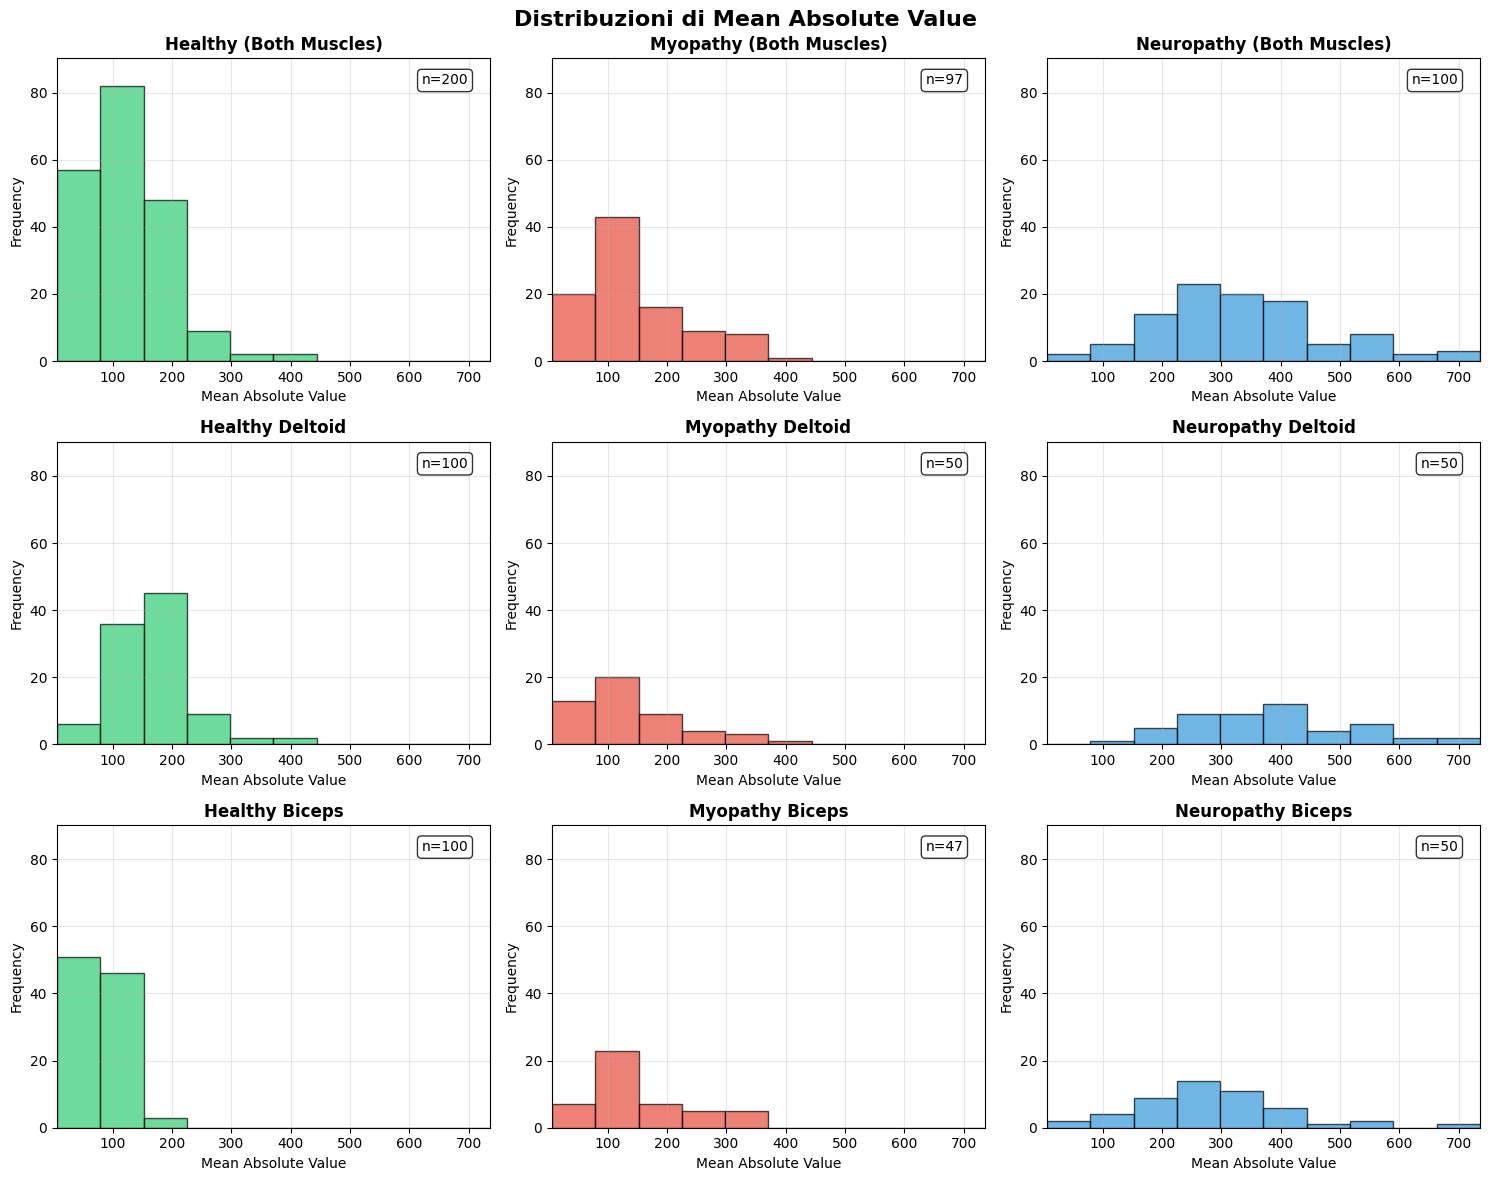

In [ ]:
def plot_feature_distributions(feature_name, df):
    """
    Plotta le distribuzioni di una feature per tutte le 9 categorie.
    
    Prima riga: Healthy, Myopathy, Neuropathy (tutti i muscoli)
    Seconda riga: Healthy Deltoid, Myopathy Deltoid, Neuropathy Deltoid
    Terza riga: Healthy Biceps, Myopathy Biceps, Neuropathy Biceps
    
    Args:
        feature_name (str): Nome della feature da plottare (deve essere in feature_columns)
        df (DataFrame): DataFrame contenente i dati
    """
    if feature_name not in feature_columns:
        print(f"Errore: '{feature_name}' non è una feature valida.")
        print(f"Feature disponibili: {feature_columns}")
        return
    
    # Definisci le condizioni e i muscoli
    conditions = ['Healthy', 'Myopathy', 'Neuropathy']
    muscles = ['Deltoid', 'Biceps']
    
    # Calcola il range globale per tutti i dati della feature
    global_min = df[feature_name].min()
    global_max = df[feature_name].max()
    
    # Calcola il numero di bin ottimale usando la regola di Sturges
    # Considera tutti i dati per avere una stima robusta
    all_data = df[feature_name].dropna()
    n_bins = int(np.ceil(np.log2(len(all_data)) + 1))
    
    # Crea i bin con range fisso
    bins = np.linspace(global_min, global_max, n_bins + 1)
    
    # Raccogli tutti gli istogrammi per trovare il massimo dell'asse y
    all_counts = []
    
    # Prima riga: tutti i muscoli combinati
    for condition in conditions:
        data = df[df['Condition'] == condition][feature_name].dropna()
        counts, _ = np.histogram(data, bins=bins)
        all_counts.append(counts)
    
    # Seconda riga: Deltoid
    for condition in conditions:
        data = df[(df['Condition'] == condition) & (df['Muscle'] == 'Deltoid')][feature_name].dropna()
        counts, _ = np.histogram(data, bins=bins)
        all_counts.append(counts)
    
    # Terza riga: Biceps
    for condition in conditions:
        data = df[(df['Condition'] == condition) & (df['Muscle'] == 'Biceps')][feature_name].dropna()
        counts, _ = np.histogram(data, bins=bins)
        all_counts.append(counts)
    
    # Trova il massimo conteggio per l'asse y
    y_max = max([counts.max() for counts in all_counts if len(counts) > 0])
    y_max = y_max * 1.1  # Aggiungi 10% di margine
    
    # Crea la figura con 3 righe e 3 colonne
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle(f'Distribuzioni di {feature_name}', fontsize=16, fontweight='bold')
    
    # Colori per le condizioni
    colors = {'Healthy': '#2ecc71', 'Myopathy': '#e74c3c', 'Neuropathy': '#3498db'}
    
    # Prima riga: tutti i muscoli
    for i, condition in enumerate(conditions):
        ax = axes[0, i]
        data = df[df['Condition'] == condition][feature_name].dropna()
        
        ax.hist(data, bins=bins, color=colors[condition], alpha=0.7, edgecolor='black')
        ax.set_title(f'{condition} (Both Muscles)', fontweight='bold')
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Frequency')
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(0, y_max)
        ax.grid(True, alpha=0.3)
        ax.text(0.95, 0.95, f'n={len(data)}', transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Seconda riga: Deltoid
    for i, condition in enumerate(conditions):
        ax = axes[1, i]
        data = df[(df['Condition'] == condition) & (df['Muscle'] == 'Deltoid')][feature_name].dropna()
        
        ax.hist(data, bins=bins, color=colors[condition], alpha=0.7, edgecolor='black')
        ax.set_title(f'{condition} Deltoid', fontweight='bold')
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Frequency')
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(0, y_max)
        ax.grid(True, alpha=0.3)
        ax.text(0.95, 0.95, f'n={len(data)}', transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Terza riga: Biceps
    for i, condition in enumerate(conditions):
        ax = axes[2, i]
        data = df[(df['Condition'] == condition) & (df['Muscle'] == 'Biceps')][feature_name].dropna()
        
        ax.hist(data, bins=bins, color=colors[condition], alpha=0.7, edgecolor='black')
        ax.set_title(f'{condition} Biceps', fontweight='bold')
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Frequency')
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(0, y_max)
        ax.grid(True, alpha=0.3)
        ax.text(0.95, 0.95, f'n={len(data)}', transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


# Esempio di utilizzo:
plot_feature_distributions('Mean Absolute Value', df)


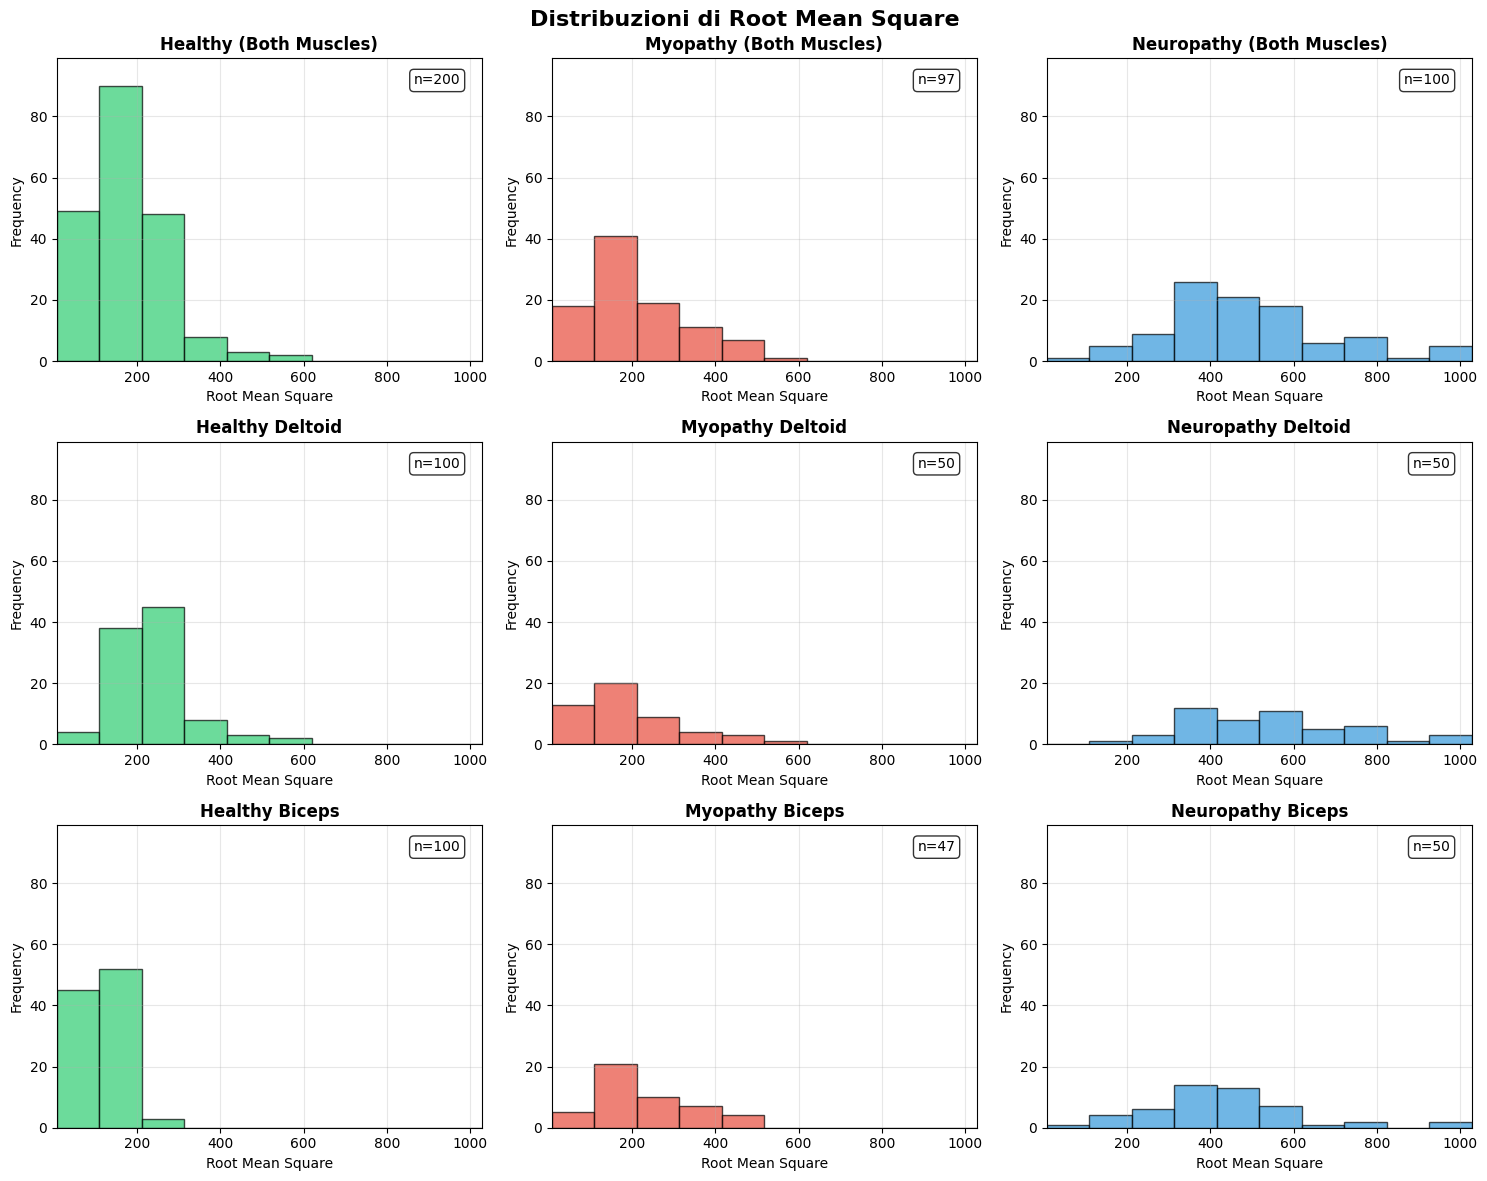

In [32]:
plot_feature_distributions('Root Mean Square', df)

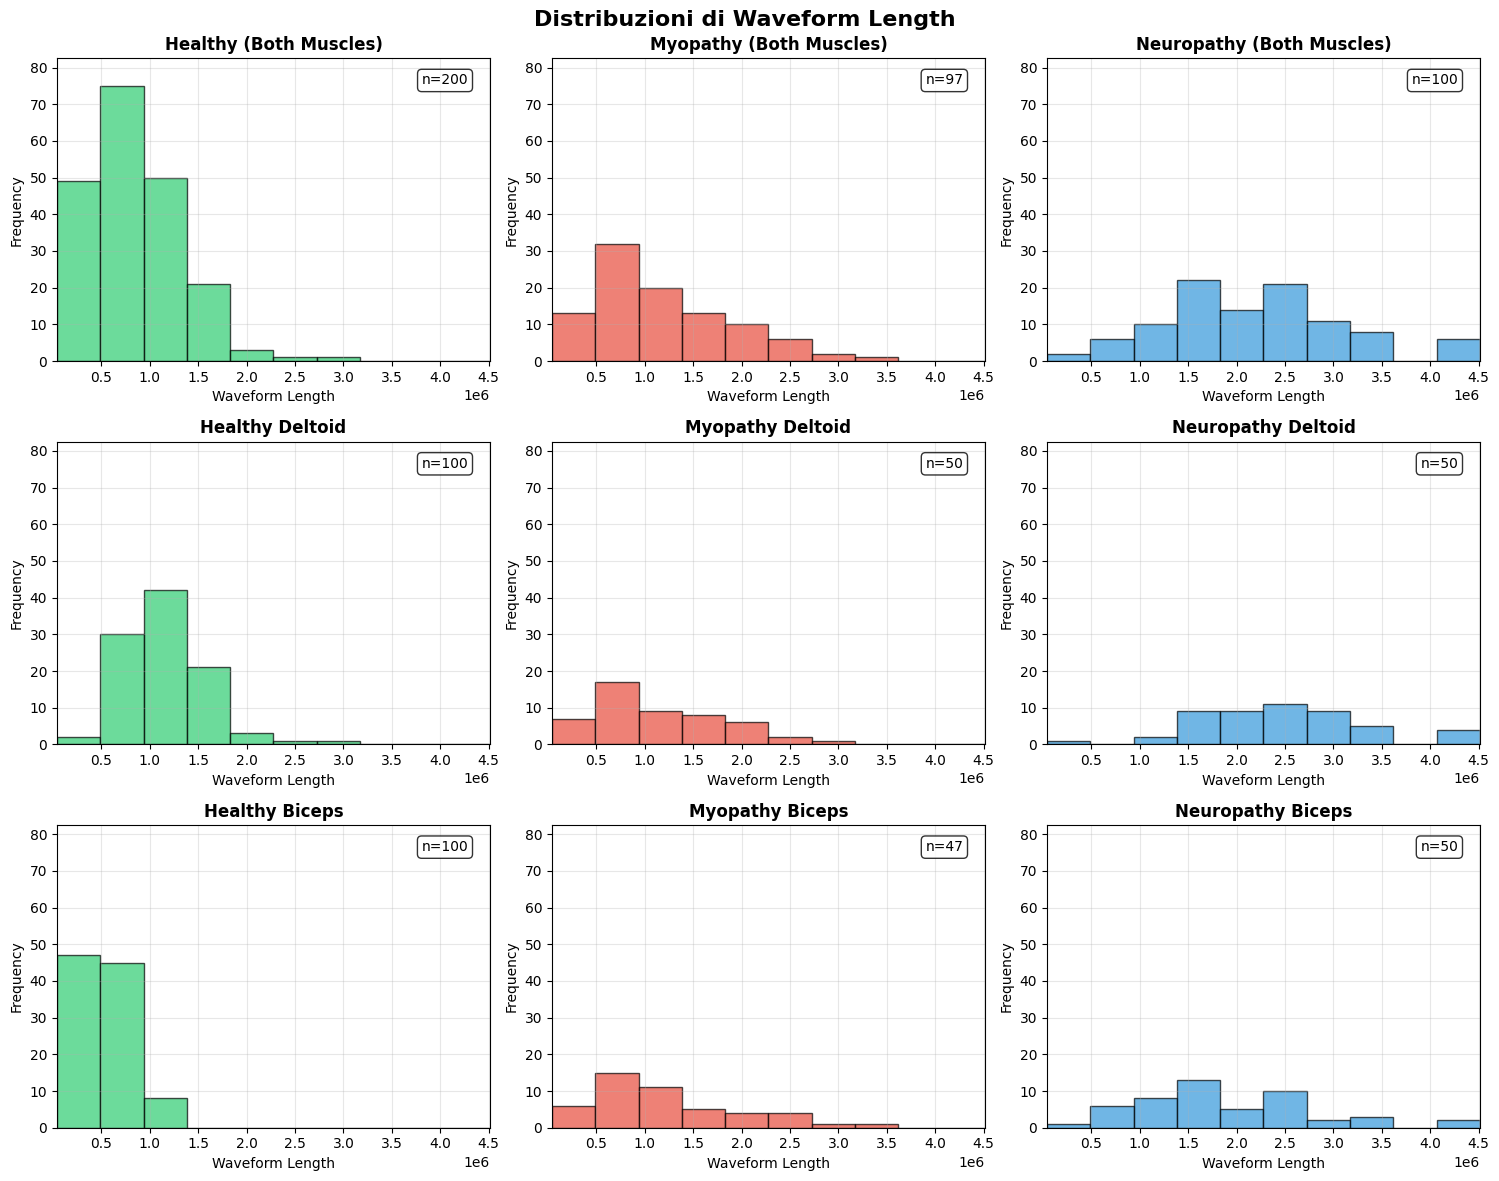

In [33]:
plot_feature_distributions('Waveform Length', df)

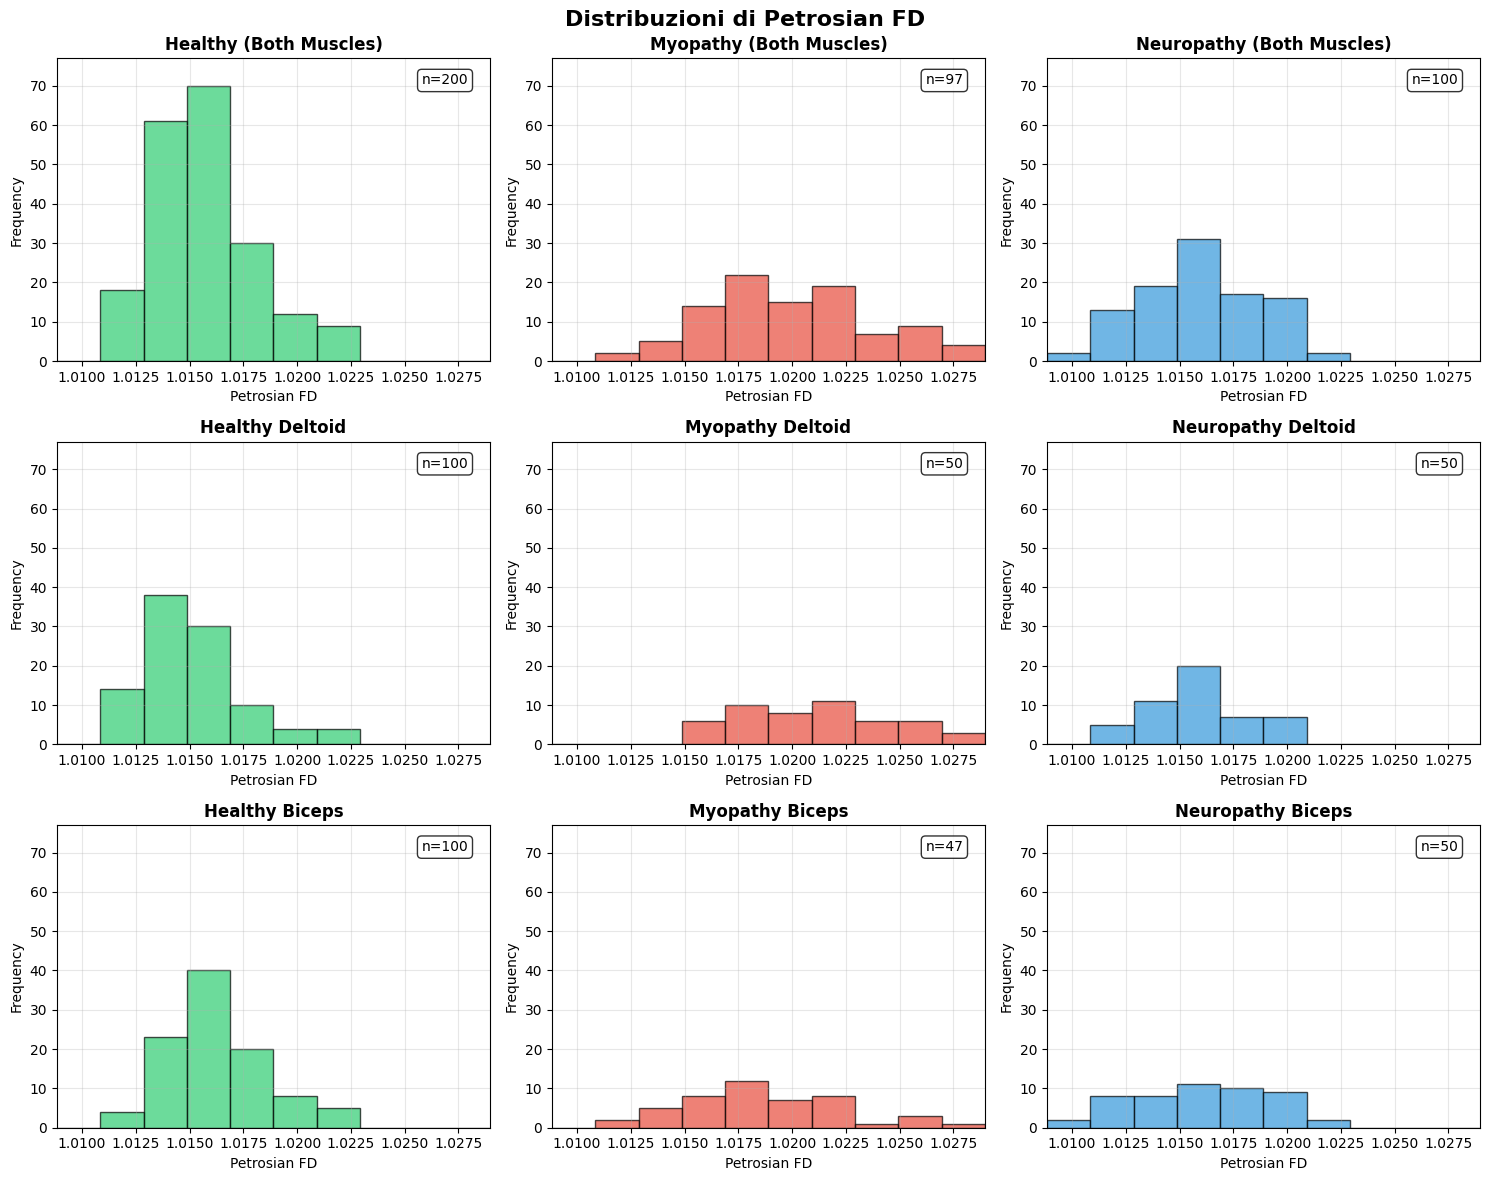

In [34]:
plot_feature_distributions('Petrosian FD', df)